In [ ]:
os._exit(0)

In [1]:
import torch
import os
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import gc
import wandb

In [2]:
config = {
    'batch_size': 512,
    'seed': 100,
    'K': 4096,
    'D': 4,
    'beta': 0.2,
    'perceptual_loss_factor': 1e-2,
    'rec_loss_factor': 1,
}

In [3]:
torch.manual_seed(config['seed'])

In [4]:
from torchvision import datasets as Datasets
from torchvision import transforms

cifar10_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


cifar10_test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#  loading training data
training_set = Datasets.CIFAR10(root='./autoencoder', download=True, train=True, transform=cifar10_train_transforms)

#  loading validation data
validation_set = Datasets.CIFAR10(root='./autoencoder', download=True, train=False, transform=cifar10_test_transforms)

# Dict for label to class
l2c = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Create data loaders
batch_size = 512
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
val_loader_shuffle = DataLoader(validation_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

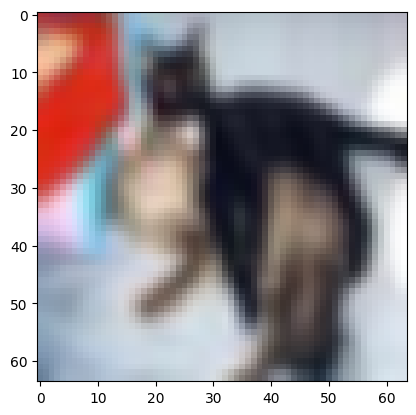

In [6]:
# Show image
img, label = next(iter(train_loader))
plt.imshow(img[0].permute(1, 2, 0)*.5+.5)

In [7]:
def xavier_init(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

In [8]:
class convBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True, act=None):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=(not batch_norm))
        self.act = nn.LeakyReLU(0.2, inplace=True) if act == None else act
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))
    
class convTBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True, act=None):
        super().__init__()
        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=(not batch_norm))
        self.act = nn.LeakyReLU(0.2, inplace=True) if act == None else act
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.convT(x)))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, batch_norm=True):
        super().__init__()
        self.conv1 = nn.Sequential(
            convBlock(in_channels, out_channels, kernel_size, stride, padding, batch_norm=batch_norm),
            convBlock(out_channels, out_channels, kernel_size, stride, padding, batch_norm=batch_norm, act=nn.Identity()),
        )
        self.conv2 = convBlock(in_channels, out_channels, 1, 1, 0, batch_norm=batch_norm, act=nn.Identity())

    def forward(self, x):
        out = self.conv1(x)
        out += self.conv2(x)
        return F.relu(out)
    
class GroupNorm(nn.Module):
    def __init__(self, num_channels, num_groups=32):
        super().__init__()
        self.gn = nn.GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)

    def forward(self, x):
        return self.gn(x)
    
class NonLocalBlock(nn.Module):
    def __init__(self, in_channels, num_groups=32):
        super().__init__()
        self.in_channels = in_channels

        self.gn = GroupNorm(in_channels, num_groups=num_groups)
        self.q = nn.Conv2d(in_channels, in_channels, 1, 1, 0)
        self.k = nn.Conv2d(in_channels, in_channels, 1, 1, 0)
        self.v = nn.Conv2d(in_channels, in_channels, 1, 1, 0)
        self.proj = nn.Conv2d(in_channels, in_channels, 1, 1, 0)

    def forward(self, x):
        x = self.gn(x)
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        B, C, H, W = x.shape

        q = q.view(B, C, -1).transpose(1, 2)   # B, HW, C
        k = k.view(B, C, -1).transpose(1, 2)   # B, HW, C
        v = v.view(B, C, -1).transpose(1, 2)   # B, HW, C

        attn = q @ k.transpose(-2, -1) / np.sqrt(C)   # B, HW, HW
        attn = F.softmax(attn, dim=-1)
        out = attn @ v                                # (B, HW, HW) @ (B, HW, C) = (B, HW, C)
        out = out.transpose(1, 2).view(B, C, H, W)    # B, C, HW -> B, C, H, W
        out = self.proj(out)
        return x + out

class VQVAE(nn.Module):
    def __init__(self, K=512, D=128, beta=0.2):
        super().__init__()
        self.K = K
        self.D = D
        self.beta = beta

        self.encoder = nn.Sequential(
            convBlock(3, 16, 4, 2, 1),
            convBlock(16, 64, 4, 2, 1),
            convBlock(64, 128, 4, 2, 1),
            ResidualBlock(128, 256, 3, 1, 1),
            NonLocalBlock(256),
            ResidualBlock(256, self.D, 3, 1, 1),
            # GroupNorm(self.D),
            # nn.SiLU(inplace=True),
            ResidualBlock(self.D, self.D, 3, 1, 1),
        )
        self.embedding = nn.Embedding(self.K, self.D)
        self.decoder = nn.Sequential(
            convTBlock(self.D, 128, 4, 2, 1),
            NonLocalBlock(128),
            convTBlock(128, 64, 4, 2, 1),
            convTBlock(64, 32, 4, 2, 1),
            convTBlock(32, 16, 3, 1, 1),
            ResidualBlock(16, 16, 3, 1, 1),
            # GroupNorm(16, num_groups=4),
            # nn.SiLU(inplace=True),
            convTBlock(16, 3, 3, 1, 1, batch_norm=False, act=nn.Tanh()),
        )

    def forward(self, x):
        z = self.encoder(x)
        B, C, H, W = z.size()
        z = z.permute(0, 2, 3, 1).contiguous().view(-1, self.D)
        z_q, min_idx, loss_vq = self.quantize(z)

        # Straight through estimation of gradients (Gradients of z_q will go to z)
        z_q = z + (z_q - z).detach()
        z_q = z_q.view(B, H, W, self.D).permute(0, 3, 1, 2)
        z_q = self.decoder(z_q)

        return z_q, min_idx, loss_vq
    
    def quantize(self, z):
        # Find pairwise distances between z and embedding vectors (This is square of the L2 norm)
        dist_sq = torch.sum(z**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1).view(-1, self.embedding.weight.size(0)) - 2 * z @ self.embedding.weight.T  # (B, K)
        min_idx = torch.argmin(dist_sq, dim=-1)         # (B*H*W,)
        z_q = self.embedding(min_idx)                   # (B*H*W, D)

        # Codebook loss + commitment loss
        loss_vq = F.mse_loss(z_q, z.detach()) + self.beta * F.mse_loss(z, z_q.detach())

        return z_q, min_idx, loss_vq
    
    def encode(self, x):
        z = self.encoder(x)
        B, C, H, W = z.size()
        z = z.permute(0, 2, 3, 1).contiguous().view(-1, self.D)
        z_q, min_idx, loss_vq = self.quantize(z)
        z_q = z_q.view(B, H, W, self.D).permute(0, 3, 1, 2)
        return z_q, min_idx, loss_vq
    
    def decode(self, z_q):
        z_q = self.decoder(z_q)
        return z_q
    
    def calculate_lambda(self, perceptual_loss, gan_loss, d=1e-6):
        last_layer_weights = self.decoder[-1].convT.weight

        # Gradient of recon loss wrt last layer of the decoder
        perceptual_loss_grad = torch.autograd.grad(perceptual_loss, last_layer_weights, retain_graph=True)[0]

        # Gradient of gan_loss wrt last layer of the decoder
        gan_loss_grad = torch.autograd.grad(gan_loss, last_layer_weights, retain_graph=True)[0]

        L = torch.norm(perceptual_loss_grad) / (torch.norm(gan_loss_grad) + d)
        L = torch.clamp(L, 0, 1e6).detach()
        return L
    
    @staticmethod
    def adopt_weight(disc_factor, i, threshold, value=0.):
        if i < threshold:
            disc_factor = value
        return disc_factor

In [9]:
# Discriminator is a patch based model (Output real/fake for patches of the image)
class Discriminator(nn.Module):
    def __init__(self, in_channels, num_filters_last=64, n_layers=3):
        super().__init__()
        layers = nn.ModuleList([
            nn.Conv2d(in_channels, num_filters_last, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        ])
        filter_mult = 1
        for i in range(1, n_layers+1):
            filter_mult_last = filter_mult
            filter_mult = min(2**i, 8)
            layers.append(nn.Conv2d(num_filters_last * filter_mult_last, num_filters_last * filter_mult, 4, 2 if i < n_layers else 1, 1, bias=False))
            layers.append(nn.BatchNorm2d(num_filters_last * filter_mult))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.Conv2d(num_filters_last * filter_mult, 1, 4, 1, 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [10]:
from collections import namedtuple

class ScalingLayer(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO : calculate mean and var for the dataset
        # The original implementation has the values of std from cnn in shift. Why?
        self.register_buffer("shift", torch.Tensor([0.0, 0.0, 0.0])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([1.0, 1.0, 1.0])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale

class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0),
        )

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleList([
            convBlock(3, 64, 4, 2, 1),
            convBlock(64, 64, 3, 1, 1),

            convBlock(64, 128, 4, 2, 1),
            convBlock(128, 128, 3, 1, 1),

            convBlock(128, 256, 4, 2, 1),
            convBlock(256, 256, 3, 1, 1),

            convBlock(256, 512, 4, 2, 1),
            convBlock(512, 512, 4, 2, 1),
        ])
        self.aux_classifier = nn.Linear(2048, 10)

    def forward(self, x):
        # Return feature representations after each conv + relu
        x1 = nn.Sequential(*self.model[:2])(x)
        x2 = nn.Sequential(*self.model[2:4])(x1)
        x3 = nn.Sequential(*self.model[4:6])(x2)
        x4 = nn.Sequential(*self.model[6:7])(x3)
        outputs = namedtuple('Outputs', ['x1', 'x2', 'x3', 'x4'])
        return outputs(x1, x2, x3, x4)
    
    def classify(self, x):
        # Add a classifier on top of the network
        cnn = nn.Sequential(*self.model)
        x = cnn(x)
        x = x.view(x.size(0), -1)
        x = self.aux_classifier(x)
        return x
    
def norm_tensor(x):
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-6)

def spatial_average(x):
    # Average over spatial dimensions
    return x.mean([2, 3], keepdim=True)     # x : B, C, H, W

class LPIPS(nn.Module):
    def __init__(self, cnn=None):
        super().__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512]
        self.cnn = cnn
        self.lins = nn.ModuleList([NetLinLayer(channels) for channels in self.channels])

    def forward(self, x, y):
        # x is real, y is fake
        x = self.cnn(x)
        y = self.cnn(y)
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(x[i]) - norm_tensor(y[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])

In [11]:
wandb.finish()

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("wandb"))
wandb.init(
    project='VQGAN_cifar10',
    entity='ritishtest1',
    id='p877jeg4',
    resume='must',

    config=config
    )

In [13]:
# Train the VGG on cifar 10
device = 'cuda'
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()

In [14]:
# Load model
cnn.load_state_dict(torch.load('cnn1.safetensors'))

/tmp/ipykernel_30/1264569578.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('cnn1.safetensors'))


<All keys matched successfully>

In [15]:
# optimizer = optim.Adam(cnn.parameters(), lr=3e-4)

In [16]:
# num_epochs = 5
# for epoch in range(num_epochs):
#     cnn.train()
#     # Training loop using tqdm loader and showing loss with the loader
#     avg_loss = 0
#     tqdm_loader = tqdm(train_loader, total=len(train_loader))
#     for i, (img, label) in enumerate(tqdm_loader):
#         img, label = img.to(device), label.to(device)
#         optimizer.zero_grad()
#         out = cnn.classify(img)
#         loss = criterion(out, label)
#         loss.backward()
#         optimizer.step()
#         tqdm_loader.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
#         tqdm_loader.set_postfix(loss=loss.item())
#         avg_loss += loss.item()
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss : {avg_loss/len(train_loader)}")

In [15]:
# Check accuracy of the network
cnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for img, label in val_loader:
        img, label = img.to(device), label.to(device)
        out = cnn.classify(img)
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
print(f'Accuracy : {100 * correct / total}')

Accuracy : 84.13


In [18]:
# torch.save(cnn.state_dict(), 'cnn1.safetensors')

In [16]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vqgan = VQVAE(K=config['K'], D=config['D'], beta=config['beta']).to(device)
xavier_init(vqgan)
discriminator = Discriminator(3).to(device)
vq_loss_fn = nn.MSELoss()
gan_loss_fn = nn.BCEWithLogitsLoss()
perceptual_loss_fn = LPIPS(cnn).to(device)
total_epochs = 35

In [18]:
# Load weights
vqgan.load_state_dict(torch.load('vqgan_4096_4.safetensors'))
discriminator.load_state_dict(torch.load('discriminator_4096_4.safetensors'))

/tmp/ipykernel_30/1147405491.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqgan.load_state_dict(torch.load('vqgan_4096_4.safetensors'))
/tmp/ipykernel_30/1147405491.p

<All keys matched successfully>

In [55]:
vq_optimizer = optim.Adam(vqgan.parameters(), lr=3e-4)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4)

In [19]:
train_cfg = {
    'perceptual_loss_factor': config['perceptual_loss_factor'],
    'rec_loss_factor': config['rec_loss_factor'],
}

In [69]:
num_epochs = 3
steps_per_epoch = len(train_loader)
logging=True

In [20]:
gc.collect()
torch.cuda.empty_cache()

In [21]:
def log_images(model, loader):
    model.eval()
    with torch.no_grad():
        img, _ = next(iter(loader))
        img = img.to(device)
        recon, _, _ = model(img)
        #img = img.cpu()
        recon = recon.detach()[:64]
        
        wandb.log({'images': [wandb.Image(img) for img in recon]}, commit=False)
    model.train()

In [26]:
log_images(vqgan, val_loader)

In [74]:
# Training loop for VQGAN
for epoch in range(num_epochs):
    vqgan.train()
    discriminator.train()
    avg_vq_loss = 0
    avg_gan_loss = 0
    avg_perceptual_loss = 0
    avg_disc_loss = 0
    tqdm_loader = tqdm(train_loader, total=len(train_loader))
    for i, (img, label) in enumerate(tqdm_loader):
        img = img.to(device)
        decoded_images, _, vq_loss = vqgan(img)

        disc_factor = vqgan.adopt_weight(1e-1, total_epochs * steps_per_epoch + i, threshold=800, value=0.)

        if disc_factor:
            disc_real = discriminator(img)
            disc_fake = discriminator(decoded_images)
            g_loss = -torch.mean(disc_fake)

        perceptual_loss = perceptual_loss_fn(img, decoded_images)
        #perceptual_loss = 0
        #rec_loss = torch.abs(img - decoded_images)
        rec_loss = F.mse_loss(img, decoded_images)
        perceptual_rec_loss = train_cfg['perceptual_loss_factor'] * perceptual_loss + train_cfg['rec_loss_factor'] * rec_loss
        perceptual_rec_loss = perceptual_rec_loss.mean()

        # Calculate lambda and update VQ loss
        if disc_factor:
            L = vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
            vq_loss = perceptual_rec_loss + vq_loss + disc_factor * L * g_loss
        else:
            vq_loss = perceptual_rec_loss + vq_loss

        if disc_factor:
            # # Hinge loss for GAN (Push real to 1, fake to -1)
            # d_loss_real = torch.mean(F.relu(1. - disc_real))
            # d_loss_fake = torch.mean(F.relu(1. + disc_fake))
            # gan_loss = disc_factor * 0.5 * (d_loss_real + d_loss_fake)

            # GAN loss
            d_loss_real = torch.mean(torch.nn.functional.softplus(-disc_real))
            d_loss_fake = torch.mean(torch.nn.functional.softplus(disc_fake))
            gan_loss = disc_factor * 0.5 * (d_loss_real + d_loss_fake)

        # VQVAE
        vq_optimizer.zero_grad()
        vq_loss.backward(retain_graph=True)

        # Discriminator
        if disc_factor:
            disc_optimizer.zero_grad()
            gan_loss.backward()

        # Update weights of both networks
        vq_optimizer.step()
        if disc_factor:
            disc_optimizer.step()

        tqdm_loader.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        if disc_factor:
            tqdm_loader.set_postfix(vq_loss=vq_loss.item(), gan_loss=gan_loss.item(), d_loss_real=d_loss_real.item(), d_loss_fake=d_loss_fake.item())
            if (logging==True and i % 40):
                wandb.log({"VQ_loss": vq_loss.item(), "gan_loss": gan_loss.item(), "d_loss_real": d_loss_real.item(), "d_loss_fake": d_loss_fake.item(), "vq_LR":vq_optimizer.param_groups[0]['lr'], "d_LR":disc_optimizer.param_groups[0]['lr']})
        else:
            tqdm_loader.set_postfix(vq_loss=vq_loss.item())
            if (logging==True and i % 40):
                wandb.log({"VQ_loss": vq_loss.item(), "vq_LR":vq_optimizer.param_groups[0]['lr']})
    total_epochs += 1
    
    if (logging and epoch%3==0):
        log_images(vqgan, val_loader)
    
    gc.collect()
    torch.cuda.empty_cache()

Epoch [3/3]: 100%|██████████| 98/98 [01:43<00:00,  1.06s/it, d_loss_fake=2.56e-5, d_loss_real=0.000123, gan_loss=7.45e-6, vq_loss=0.0269] 


In [75]:
print(total_epochs)

35


In [76]:
# torch.save(vqgan.state_dict(), 'vqgan_4096_4.safetensors')
# torch.save(discriminator.state_dict(), 'discriminator_4096_4.safetensors')

In [26]:
def show_reconstructions(model, loader, figsize=(16,4)):
    model.eval()
    with torch.no_grad():
        img, _ = next(iter(loader))
        img = img.to(device)
        recon, _, _ = model(img)
        img = img.cpu()
        recon = recon.detach().cpu()

        fig, axes = plt.subplots(2, 8, figsize=figsize)
        for i in range(8):
            axes[0, i].imshow(img[i].permute(1, 2, 0)*.5+.5)
            axes[1, i].imshow(recon[i].permute(1, 2, 0)*.5+.5)
            axes[0, i].axis('off')
            axes[1, i].axis('off')

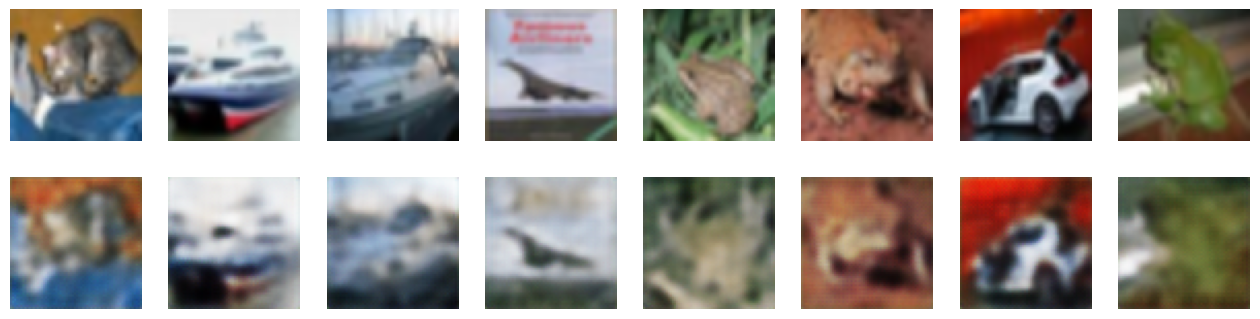

In [27]:
show_reconstructions(vqgan, val_loader)

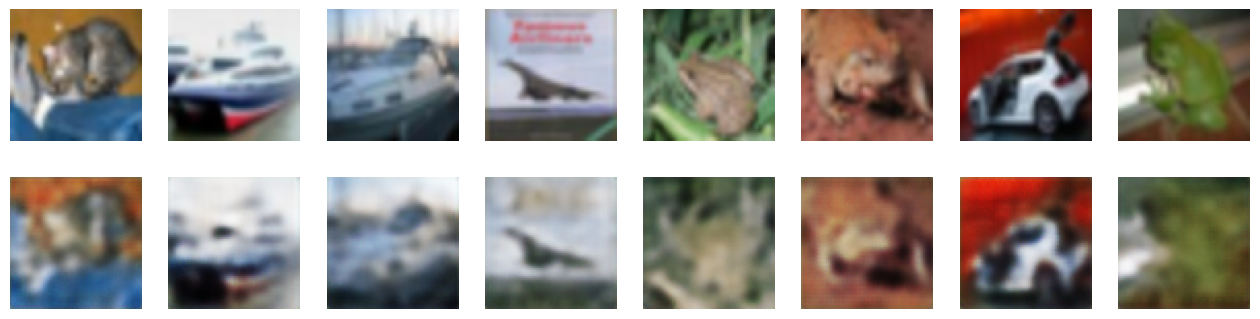

In [77]:
# show_reconstructions(vqgan, val_loader)

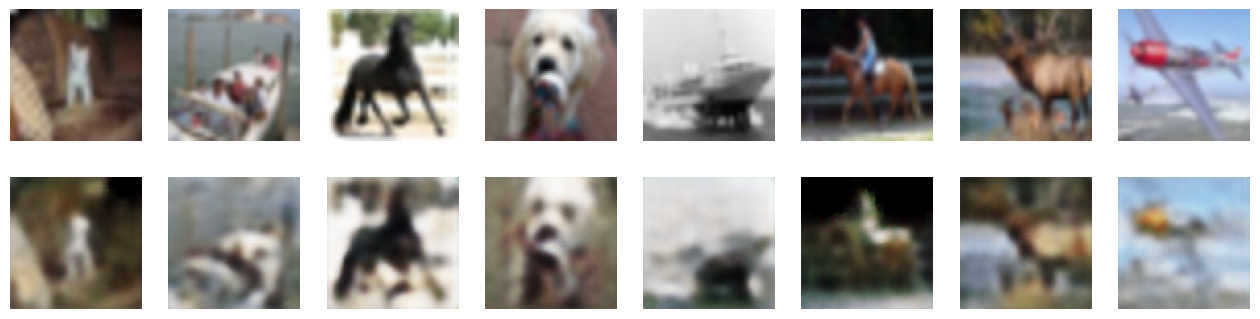

In [24]:
show_reconstructions(vqgan, val_loader_shuffle)

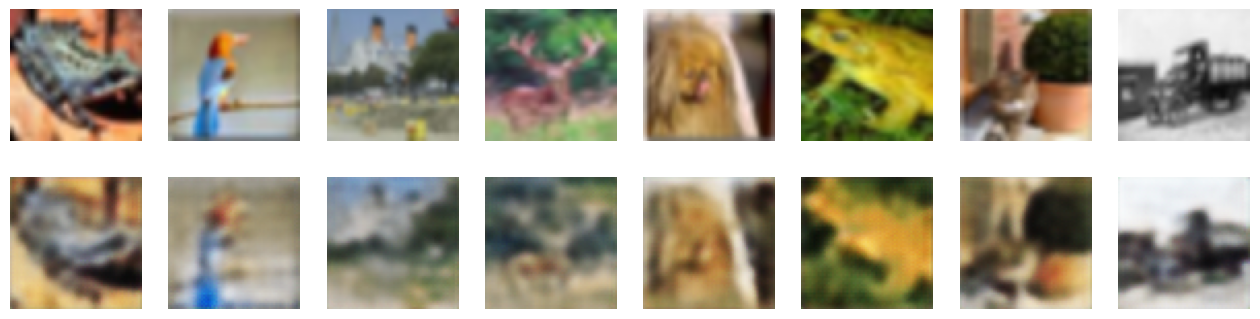

In [25]:
show_reconstructions(vqgan, val_loader_shuffle)  # (4096, 4) @ 5 epochs

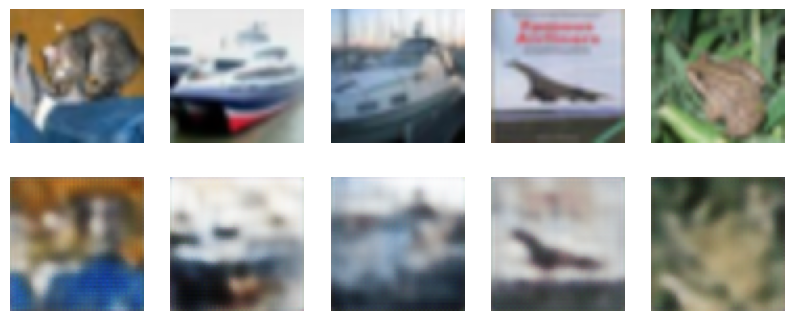

In [352]:
show_reconstructions(vqgan, val_loader)      # (2048, 8) @ 6 epochs

In [28]:
gc.collect()
torch.cuda.empty_cache()

torch.Size([512, 4, 8, 8])


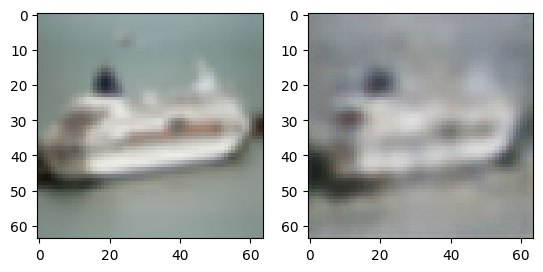

In [83]:
# Encode image
img, _ = next(iter(train_loader))
img = img.to(device)
z_q, min_idx, loss_vq = vqgan.encode(img)

print(z_q.shape)

# Decode image
decoded_img = vqgan.decode(z_q)

# Plot
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[0].cpu().permute(1, 2, 0)*.5+.5)
ax[1].imshow(decoded_img[0].detach().cpu().permute(1, 2, 0)*.5+.5)

In [29]:
config_small = {
    'n_embed': 512,
    'n_layer': 4,
    'n_head': 16,
    'attn_drop': 0.,
    'resid_drop': 0.,
    'embd_drop': 0.,
    'sos_token': 4096,
    'block_size': 64,   # H*W (z_quantized is of shape B, out_channels, H, W) => H*W codebook vectors of dimension out_channels each
    'dropout': 0.,
    'pkeep': 0.8,
    'vocab_size': 4097,  # Number of embeddings in the codebook
    'out_channels': 4,
    'h': 8,
    'w': 8,
}

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, causal, config):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.causal = causal
        self.q_attn = nn.Linear(config['n_embed'], config['n_embed'], bias=False)
        self.kv_attn = nn.Linear(config['n_embed'], config['n_embed'] * 2, bias=False)
        self.c_proj = nn.Linear(config['n_embed'], config['n_embed'], bias=False)             # Combine the outputs of the heads
        self.attn_dropout = nn.Dropout(config['dropout'])
        self.resid_dropout = nn.Dropout(config['dropout'])

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

        if not self.flash:
            print("WARNING: using slow attention.")
            self.register_buffer("tril", torch.tril(torch.ones(config['block_size'], config['block_size'])).view(1, 1, config['block_size'], config['block_size']))

    def forward(self, x, y=None, mask=None):
        B, T_dec, C = x.shape

        if y is None:
            y = x

        B, T_enc, C = y.shape

        # Query from the decoder
        q = self.q_attn(x).view(B, T_dec, self.num_heads, self.head_size).transpose(1, 2)  # (B,T_dec,C) -> (B,T_dec,nh,hs) -> (B,nh,T_dec,hs)
        k, v = self.kv_attn(y).split(C, dim=-1)                                 # (B,T_enc,2C) -> 2*(B,T_enc,C)
        k = k.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)
        v = v.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)

        if self.flash:
            out = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=mask, is_causal=self.causal)
        else:
            wei = q @ k.transpose(-2, -1) * 1.0 / np.sqrt(k.size(-1))         # (B,nh,T_dec,hs) @ (B,nh,hs,T_enc) -> (B,nh,T_dec,T_enc)
            if self.causal:
                if mask is None:
                    # Lower triangular mask to mask future tokens
                    wei = wei.masked_fill(self.tril[:, :, :T_dec, :T_enc] == 0, float('-inf')) # (B,nh,T_dec,T_enc)
                else:
                    wei = wei.masked_fill(mask == 0, float('-inf'))             # (B,nh,T_dec,T_enc)
            wei = F.softmax(wei, dim=-1)                                        # (B,nh,T_dec,T_enc)

            wei = self.attn_dropout(wei)
            out = wei @ v                                                       # (B,nh,T_dec,T_enc) @ (B,nh,T_enc,hs) -> (B,nh,T_dec,hs)

        out = out.transpose(1, 2).contiguous().view(B, T_dec, -1)               # (B,T_dec,nh*hs) = (B,T_dec,C)
        out = self.resid_dropout(self.c_proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config['n_embed'], 4 * config['n_embed']),
            nn.GELU(),
            nn.Linear(4 * config['n_embed'], config['n_embed']),
            nn.Dropout(config['dropout']),
        )

    def forward(self, x):
        return self.net(x)
    
class DecoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, config, cross=False):
        # n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.cross = cross
        head_size = config['n_embed'] // config['n_head']
        self.sa = MultiHeadAttention(config['n_head'], head_size, causal=True, config=config)                # Masked MHA
        if self.cross:
            # Cross attention block
            self.cross_sa = MultiHeadAttention(config['n_head'], head_size, causal=False, config=config)     # Cross MHA
            self.ln2 = nn.LayerNorm(config['n_embed'])
        self.ffwd = FeedFoward(config)
        self.ln1 = nn.LayerNorm(config['n_embed'])
        self.ln3 = nn.LayerNorm(config['n_embed'])

    def forward(self, x, y=None):
        x = x + self.sa(self.ln1(x))
        if self.cross:
            x = x + self.cross_sa(self.ln2(x), y)
        x = x + self.ffwd(self.ln3(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding_table = nn.Embedding(config['vocab_size'], config['n_embed'])
        self.pos_emb = nn.Parameter(torch.zeros(1, config['block_size'], config['n_embed']))
        self.drop = nn.Dropout(config['embd_drop'])

        # Decoder blocks with causal self attn
        self.blocks = nn.Sequential(*[DecoderBlock(config, cross=False) for _ in range(config['n_layer'])])

        self.ln_f = nn.LayerNorm(config['n_embed'])
        self.head = nn.Linear(config['n_embed'], config['vocab_size'], bias=False)

    def forward(self, x, target=None):
        B, T_dec = x.shape
        x = self.token_embedding_table(x) + self.pos_emb[:, :T_dec]
        x = self.drop(x)
        x = self.blocks(x)
        x = self.head(self.ln_f(x))
        loss = None
        if target is not None:
            loss = F.cross_entropy(x.view(-1, x.size(-1)), target.view(-1))
        return x, loss

In [31]:
class VQGANTransformer(nn.Module):
    '''A transformer trained on VQGAN codebook features to generate images from text.'''
    def __init__(self, config, vqgan=None, transformer=None):
        super().__init__()
        self.sos_token = config['sos_token']
        self.config = config

        self.vqgan = vqgan
        if transformer:
            self.transformer = transformer
        else:
            self.transformer = GPT(config)
        self.pkeep = config['pkeep']

        # Freeze vqgan
        for param in self.vqgan.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def encode_to_z(self, x):
        z_q, indices, _ = self.vqgan.encode(x)
        indices = indices.view(z_q.shape[0], -1)   # z_q : (B,C,H,W); indices : (B,HW)
        return z_q, indices

    @torch.no_grad()
    def z_to_img(self, indices):
        # Remove the sos token from the image
        if (indices[:, 0] == self.sos_token).all():
            indices = indices[:, 1:]

        # Get the codebook vectors
        ix2vec = self.vqgan.embedding(indices).reshape(indices.shape[0], self.config['h'], self.config['w'], self.config['out_channels'])
        ix2vec = ix2vec.permute(0, 3, 1, 2)         # (B,C,H,W)

        # Decode the codebook vectors to get the image
        return self.vqgan.decode(ix2vec)
    
    def forward(self, x, debug=False):
        _, indices = self.encode_to_z(x)

        sos_tokens = torch.ones(x.shape[0], 1).long().to(x.device) * self.sos_token

        # Create a mask for the tokens
        mask = torch.bernoulli(self.pkeep * torch.ones(indices.shape, device=x.device)).round().to(dtype=torch.int64)

        # Add new indices in place of the masked ones
        random_indices = torch.randint_like(indices, self.transformer.config['vocab_size'])

        new_indices = mask * indices + (1 - mask) * random_indices
        new_indices = torch.cat([sos_tokens, new_indices], dim=1)
        target = indices

        # Transformer will predict original indices given new_indices
        logits, loss = self.transformer(new_indices[:, :-1], target=target)

        if debug:
            print("Context", new_indices[:, :-1][0])
            print("Target", target[0])
            print("Predictions", logits[0].max(axis=1)[1])

        return logits, loss, target
    
    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[:, [-1]]] = -float('inf')       # Set all logits less than the kth largest to -inf
        return out
    
    @torch.no_grad()
    def sample(self, x, c, steps, temp=1.0, top_k=100):
        self.transformer.eval()

        x = torch.cat((c, x), dim=1)

        # # Take the last (block size) tokens
        # x = x[:, -self.config['block_size']:]

        for _ in range(steps):
            logits, loss = self.transformer(x)
            logits = logits[:, -1, :] / temp
            if top_k is not None:
                logits = self.top_k_logits(logits, top_k)
            probs = F.softmax(logits, dim=-1)
            ix = torch.multinomial(probs, num_samples=1)
            x = torch.cat((x, ix), dim=1)

        # x = x[:, c.shape[1]:]       # Remove the context tokens
        self.transformer.train()
        return x

In [32]:
# Initialize transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
vqgan_transformer = VQGANTransformer(config_small, vqgan).to(device)

In [77]:
vqgan_transformer.load_state_dict(torch.load("vqgan_transformer.safetensors"))

/tmp/ipykernel_30/1896395263.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqgan_transformer.load_state_dict(torch.load("vqgan_transformer.safetensors"))


<All keys matched successfully>

In [ ]:
vqgan_transformer.pkeep = 0.6

Changing pkeep to 0.6 from 0.8


In [102]:
# Optimizer
optimizer = optim.Adam(vqgan_transformer.parameters(), lr=1e-4)

num_epochs = 30
steps_per_epoch = len(train_loader)
logging=True

gc.collect()
torch.cuda.empty_cache()

In [103]:
# training loop
for epoch in range(num_epochs):
    vqgan_transformer.train()
    avg_loss = 0
    tqdm_loader = tqdm(train_loader, total=len(train_loader))
    for i, (img, label) in enumerate(tqdm_loader):
        img = img.to(device)
        optimizer.zero_grad()
        logits, loss, target = vqgan_transformer(img, debug=False)
        # logits, loss, target = vqgan_transformer(img, debug=True)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        # Tracking
        tqdm_loader.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        tqdm_loader.set_postfix(loss=loss.item())
        
        if logging:
            wandb.log({"transformer_loss":loss.item()})
        avg_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss : {avg_loss/len(train_loader)}")
    
    if ((1+epoch) % 5 == 0):
        vqgan_transformer.eval()

        # Create a 4x4 grid of generations and plot them
        sos_token = torch.ones(16, 1).long().to(device) * vqgan_transformer.sos_token

        # Use val_loader instead of val_loader_shuffle
        img, label = next(iter(val_loader))
        _, c = vqgan_transformer.encode_to_z(img.to(device))

        context_n = 32
        c = c[:16, :context_n]

        sample = vqgan_transformer.sample(c, sos_token, config_small['block_size'] - context_n, temp=1.0, top_k=5)
        sample = vqgan_transformer.z_to_img(sample)
        sample = sample.detach().cpu().permute(0, 2, 3, 1).numpy()

        # Save generated images to a buffer to log into wandb
        generated_images = []
        for i in range(16):
            img_arr = sample[i] * 0.5 + 0.5  # Scale to [0, 1] range
            generated_images.append(wandb.Image(img_arr, caption=f"Generated Image {i+1}"))

        wandb.log({"generated_images": generated_images}, commit=False)

    # Free memory
    gc.collect()
    torch.cuda.empty_cache()

Epoch [1/30]: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s, loss=4.56]


Epoch [1/30], Loss : 4.5371149900008225


Epoch [2/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.48]


Epoch [2/30], Loss : 4.536928103894604


Epoch [3/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.5] 


Epoch [3/30], Loss : 4.537894302484941


Epoch [4/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.51]


Epoch [4/30], Loss : 4.536850685975989


Epoch [5/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.56]

Epoch [5/30], Loss : 4.534012590135847



Epoch [6/30]: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s, loss=4.54]


Epoch [6/30], Loss : 4.53344818523952


Epoch [7/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.61]


Epoch [7/30], Loss : 4.535949619448915


Epoch [8/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.61]


Epoch [8/30], Loss : 4.5356689229303475


Epoch [9/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.55]


Epoch [9/30], Loss : 4.534054439895007


Epoch [10/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.57]

Epoch [10/30], Loss : 4.5338407633255935



Epoch [11/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.55]


Epoch [11/30], Loss : 4.532827391916392


Epoch [12/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.59]


Epoch [12/30], Loss : 4.530937832228991


Epoch [13/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.53]


Epoch [13/30], Loss : 4.531688592871841


Epoch [14/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.47]


Epoch [14/30], Loss : 4.530911314244173


Epoch [15/30]: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s, loss=4.53]

Epoch [15/30], Loss : 4.531581786214089



Epoch [16/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.56]


Epoch [16/30], Loss : 4.5297195084240975


Epoch [17/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.55]


Epoch [17/30], Loss : 4.532815724003072


Epoch [18/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.56]


Epoch [18/30], Loss : 4.530718973704746


Epoch [19/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.48]


Epoch [19/30], Loss : 4.5302969582226815


Epoch [20/30]: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s, loss=4.55]

Epoch [20/30], Loss : 4.530147518430438



Epoch [21/30]: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s, loss=4.56]


Epoch [21/30], Loss : 4.530054165392506


Epoch [22/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.54]


Epoch [22/30], Loss : 4.531943549915236


Epoch [23/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.55]


Epoch [23/30], Loss : 4.530465057918003


Epoch [24/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.57]


Epoch [24/30], Loss : 4.529252066904185


Epoch [25/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.59]

Epoch [25/30], Loss : 4.527481156952527



Epoch [26/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.54]


Epoch [26/30], Loss : 4.530583021592121


Epoch [27/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.55]


Epoch [27/30], Loss : 4.528504576001849


Epoch [28/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.58]


Epoch [28/30], Loss : 4.527787602677638


Epoch [29/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.49]


Epoch [29/30], Loss : 4.528566555101044


Epoch [30/30]: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s, loss=4.58]

Epoch [30/30], Loss : 4.52681548741399


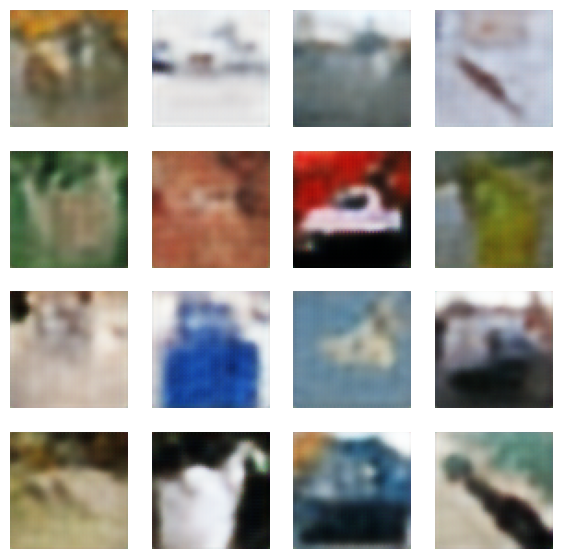

In [ ]:
vqgan_transformer.eval()

# Create a 4x4 grid of generations and plot them
sos_token = torch.ones(16, 1).long().to(device) * vqgan_transformer.sos_token

# Use val_loader instead of val_loader_shuffle
img, label = next(iter(val_loader))
_, c = vqgan_transformer.encode_to_z(img.to(device))

context_n = 32
c = c[:16, :context_n]  # Take the first 16 images and no context

sample = vqgan_transformer.sample(c, sos_token, config_small['block_size'] - context_n, temp=1.0, top_k=5)
sample = vqgan_transformer.z_to_img(sample)
sample = sample.detach().cpu().permute(0, 2, 3, 1)
sample = sample.numpy()

# Plot the generated images
fig, axs = plt.subplots(4, 4, figsize=(7, 7))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(sample[i*4+j]*.5+.5)
        axs[i, j].axis('off')

# Save generated images to a buffer to log into wandb
generated_images = []
for i in range(16):
    img_arr = sample[i] * 0.5 + 0.5  # Scale to [0, 1] range
    generated_images.append(wandb.Image(img_arr, caption=f"Generated Image {i+1}"))

# # Log generated images to wandb
# wandb.log({"generated_images": generated_images}, commit=False)

# # Plot the original images
# fig, axs = plt.subplots(4, 4, figsize=(7, 7))
# for i in range(4):
#     for j in range(4):
#         axs[i, j].imshow(img[i*4+j].permute(1, 2, 0)*.5+.5)
#         axs[i, j].axis('off')

# # Save original images to a buffer to log into wandb
# original_images = []
# img_np = img.detach().cpu().permute(0, 2, 3, 1).numpy()
# for i in range(16):
#     img_arr = img_np[i] * 0.5 + 0.5  # Scale to [0, 1] range
#     original_images.append(wandb.Image(img_arr, caption=f"Original Image {i+1}"))

# # Log original images to wandb without committing the run (commit=False)
# wandb.log({"original_images": original_images}, commit=False)

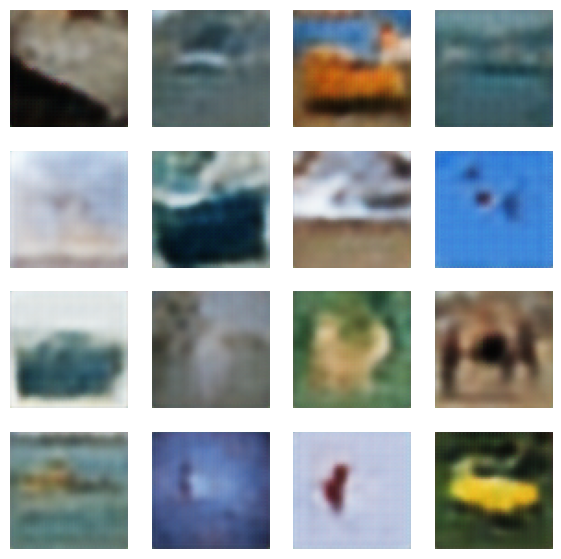

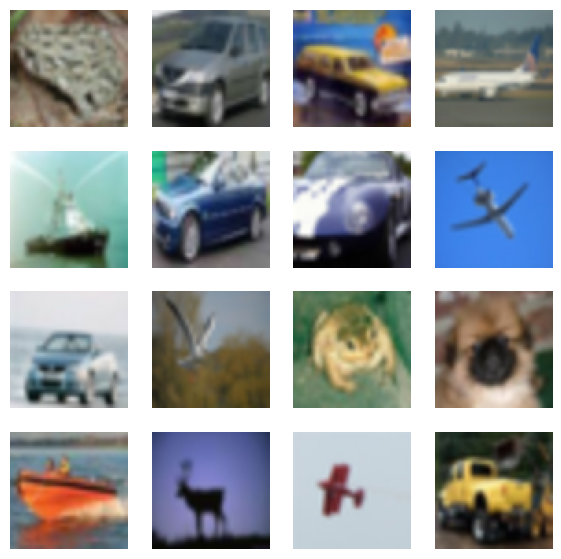

In [108]:
# Create a sos token and sample from the model
vqgan_transformer.eval()

# Create a 4x4 grid of generations and plot them
sos_token = torch.ones(16, 1).long().to(device) * vqgan_transformer.sos_token

# Get context from passing images through the encoder
img, label = next(iter(val_loader_shuffle))
_, c = vqgan_transformer.encode_to_z(img.to(device))
# print(c[:16])

# Trained on context length of 64
context_n = 32
c = c[:16, :context_n]      # Take the first 16 images and context_n tokens as context
# print(c.T)
sample = vqgan_transformer.sample(c, sos_token, config_small['block_size'] - context_n, temp=1.0, top_k=5)
# print(sample.shape)
sample = vqgan_transformer.z_to_img(sample)
sample = sample.detach().cpu().permute(0, 2, 3, 1)
sample = sample.numpy()
fig, axs = plt.subplots(4, 4, figsize=(7, 7))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(sample[i*4+j]*.5+.5)
        axs[i, j].axis('off')

# Plot the original images
fig, axs = plt.subplots(4, 4, figsize=(7, 7))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(img[i*4+j].permute(1, 2, 0)*.5+.5)
        axs[i, j].axis('off')

In [109]:
torch.save(vqgan_transformer.state_dict(), 'vqgan_transformer_4096_4.safetensors')

In [ ]:
# img, _ = next(iter(train_loader))
# z_q, _ = vqgan_transformer.encode_to_z(img.to(device))
# decoded_img = vqgan_transformer.z_to_img(z_q)
# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(img[0].permute(1, 2, 0)*.5+.5)
# axs[1].imshow(decoded_img[0].permute(1, 2, 0)*.5+.5)

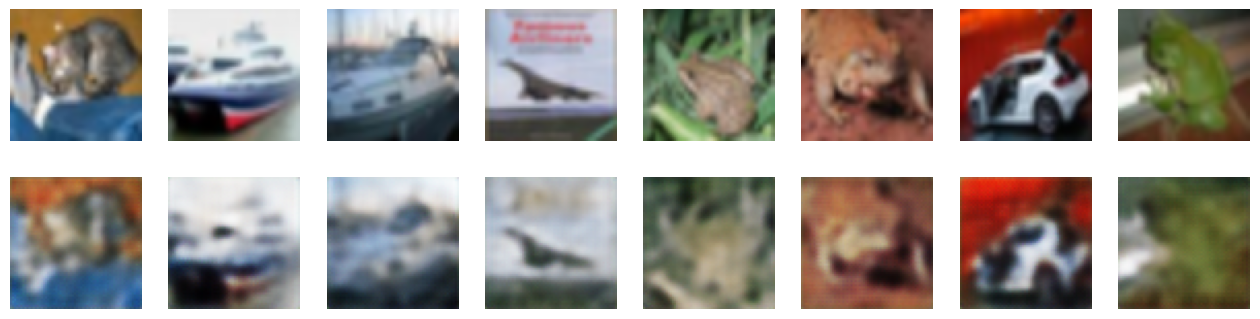

In [37]:
show_reconstructions(vqgan, val_loader)

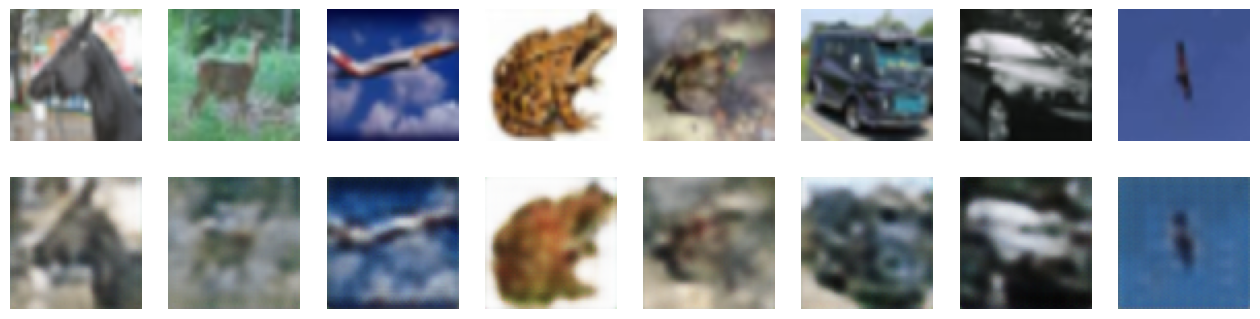

In [35]:
show_reconstructions(vqgan, val_loader_shuffle)